### What is this notebook trying to answer?
1. **Is perp "basis" predictable?** Funding rate is treated as a proxy for basis (premium/discount vs spot). If funding is persistent ("sticky"), basis is persistent.
1. **If it’s predictable, can you harvest it with a simple strategy?** Strategy = long spot + short perp for the coins where you expect positive funding (i.e., shorts receive funding), rotated daily into the strongest candidates.
1. **What part of PnL drives the returns?** They decompose PnL into: spot/perp price moves (basis change), funding earned, trading costs

### Load perpetual funding rate history

In [2]:
# Import and preprocess data

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import numpy as np

# Load the funding rate data from CSV
df_funding = pd.read_csv('binance_funding_rate_history.csv')

# Convert funding_time to datetime
df_funding['funding_time'] = pd.to_datetime(df_funding['funding_time'])

# Convert funding_rate and mark_price to numeric
df_funding['funding_rate'] = pd.to_numeric(df_funding['funding_rate'])
df_funding['mark_price'] = pd.to_numeric(df_funding['mark_price'])

# Create a dictionary of dataframes, one per symbol
df_by_symbol = {
    symbol: df_funding[df_funding['symbol'] == symbol].copy() 
    for symbol in df_funding['symbol'].unique()
}

# Resample to daily frequency (aggregate funding rates per day)
df_daily_list = []
for symbol, df in df_by_symbol.items():
    df_daily = (df.set_index('funding_time')
                  .resample('D')['funding_rate']
                  .sum()
                  .to_frame())
    df_daily['symbol'] = symbol
    df_daily_list.append(df_daily)

# Combine all symbols into one dataframe
df_daily = pd.concat(df_daily_list)

# Pivot to wide format for easier analysis
df_daily_wide = (df_daily.reset_index()
                         .pivot(index='funding_time', 
                                columns='symbol', 
                                values='funding_rate'))


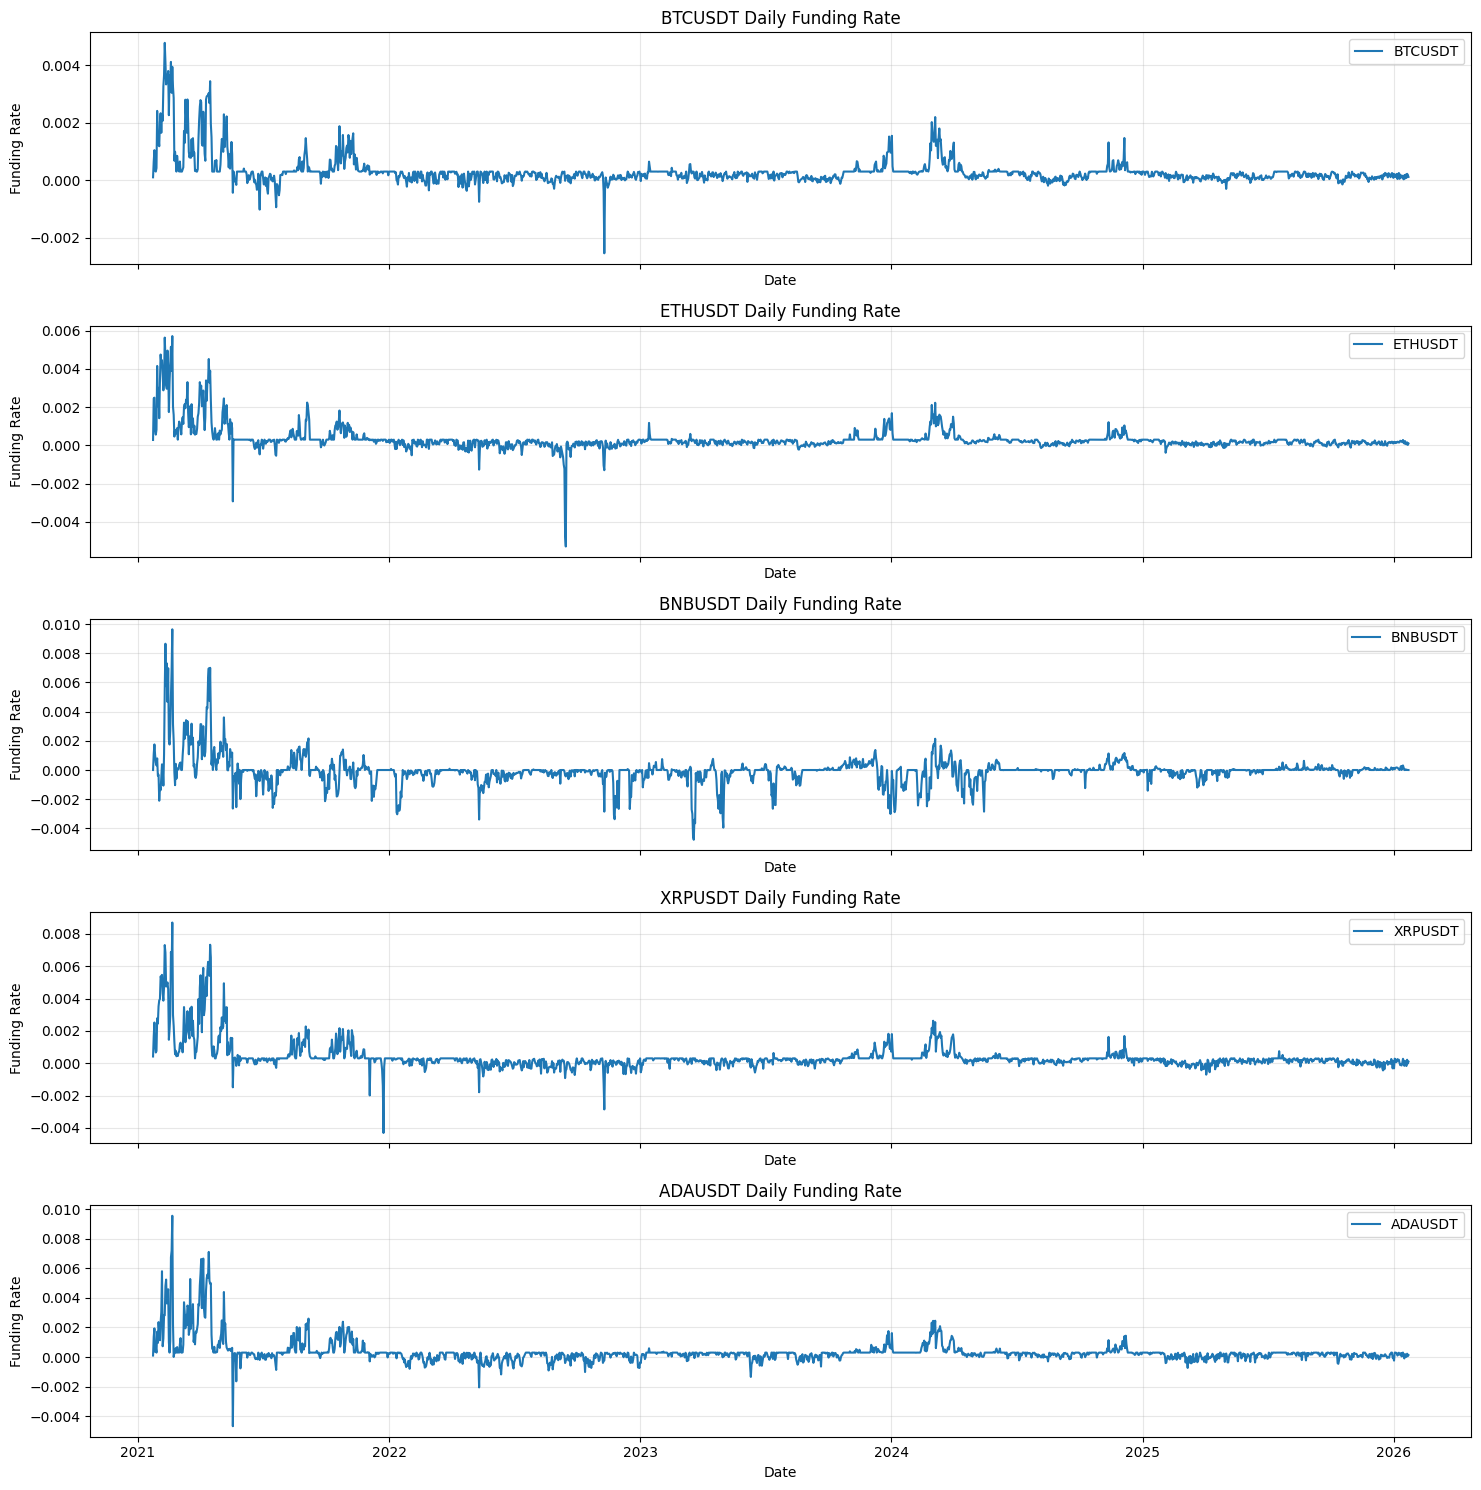

In [3]:
# Plot a couple of symbol's daily funding rate separately

symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

fig, axes = plt.subplots(len(symbols), 1, figsize=(15, 3 * len(symbols)), sharex=True)

for idx, symbol in enumerate(symbols):
    axes[idx].plot(df_daily_wide.index, df_daily_wide[symbol], label=symbol)
    axes[idx].set_title(f'{symbol} Daily Funding Rate')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Funding Rate')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Testing basis predictability using ACF/PACF on funding

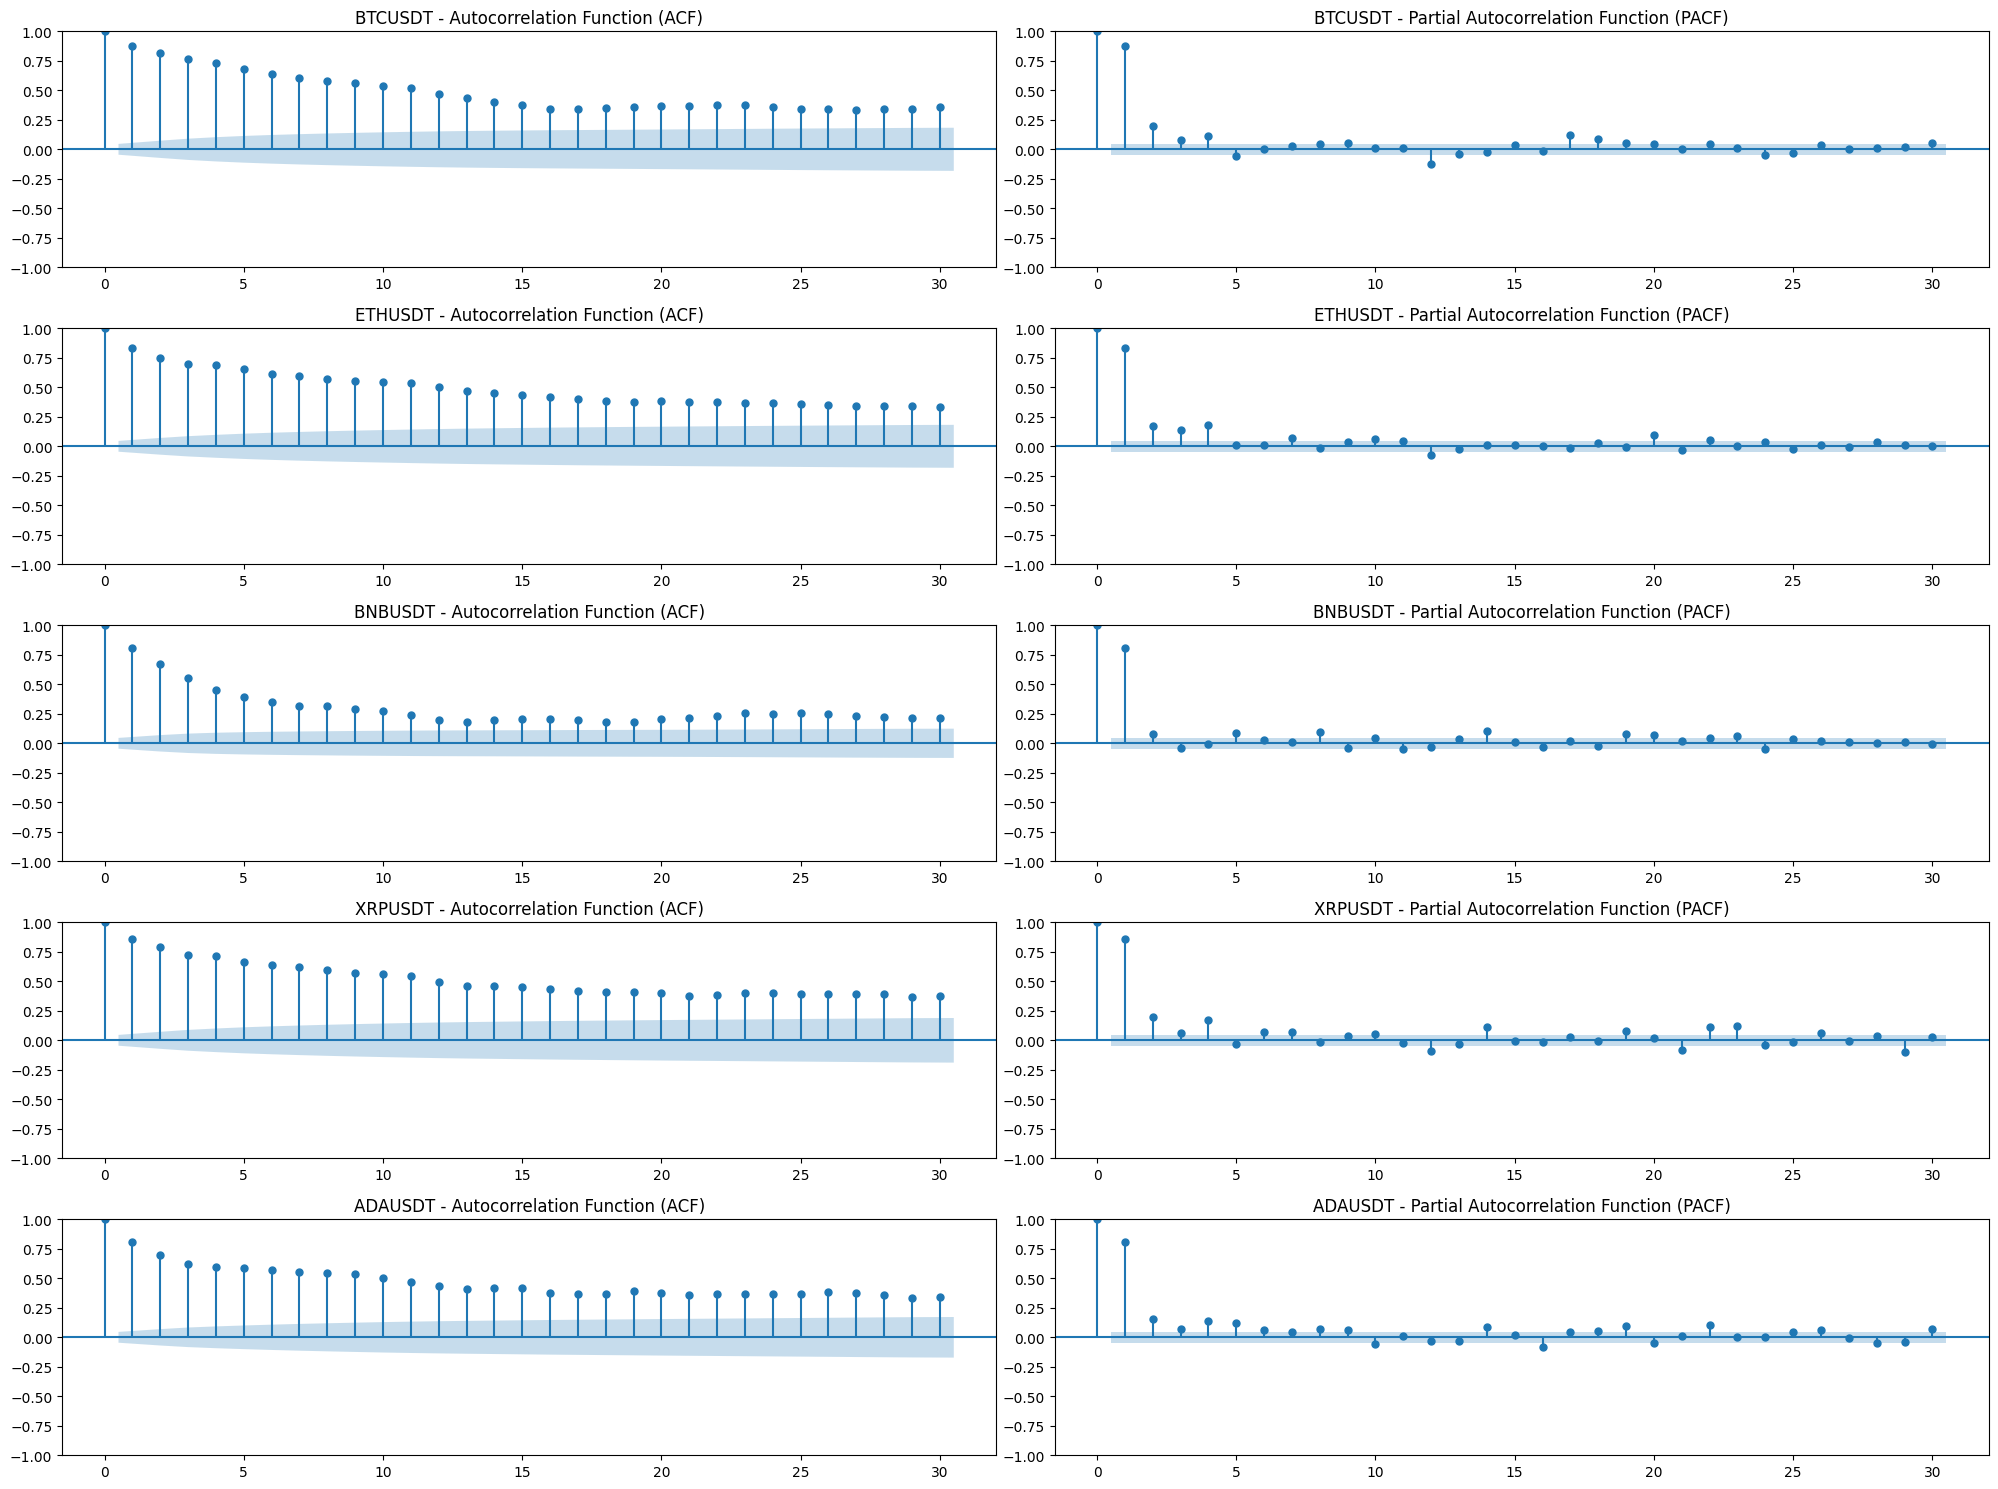

In [4]:
# Create subplots for ACF and PACF for each symbol

fig, axes = plt.subplots(len(symbols), 2, figsize=(20, 3 * len(symbols)))

for idx, symbol in enumerate(symbols):
    # Plot ACF
    plot_acf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{symbol} - Autocorrelation Function (ACF)')
    
    # Plot PACF
    plot_pacf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{symbol} - Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Estimating break-even holding horizon

**Logic**: To profit from funding rate arbitrage, the cumulative funding earned must exceed round-trip trading costs. The break-even holding period is approximately:

$$\text{Holding Period (days)} \approx \frac{\text{Round-trip Trading Cost (\%)}}{\text{Average Daily Funding Rate (\%)}}$$

**Binance Spot Trading Costs** (assuming VIP 0):
- Maker: 0.1% per side → **0.2% round-trip**
- Taker: 0.1% per side → **0.2% round-trip**

**Binance Futures Trading Costs** (assuming VIP 0):
- Maker: 0.02% per side → **0.04% round-trip**
- Taker: 0.05% per side → **0.10% round-trip**

We'll consider the worst case scenario, which amounts to **0.2%** for two spot transactions and **0.10%** for two futures transactions, together **0.30%**.

In [36]:
# Calculate average funding rate for each symbol
avg_funding_by_symbol = df_daily_wide.mean()

# Filter only positive average funding rates
positive_avg_funding = avg_funding_by_symbol[avg_funding_by_symbol > 0]

# Calculate the overall average of positive funding rates
overall_avg_positive = positive_avg_funding.mean()
print(f"Number of symbols with positive average funding: {len(positive_avg_funding)}")
print(f"Overall average of positive funding rates: {overall_avg_positive:.6f} ({overall_avg_positive * 100:.4f}%)")

# Calculate break-even holding period for positive funding symbols
round_trip_cost = 0.003  # 0.3%
breakeven_days = round_trip_cost / abs(avg_funding_by_symbol.mean())
breakeven_days_positive = round_trip_cost / abs(overall_avg_positive)

print(f"\nBreak-even holding period:")
print(f"Round-trip trading cost: {round_trip_cost * 100:.2f}%")
print(f"Break-even period (overall avg): {breakeven_days:.2f} days")
print(f"Break-even period (positive funding avg): {breakeven_days_positive:.2f} days")

Number of symbols with positive average funding: 333
Overall average of positive funding rates: 0.000374 (0.0374%)

Break-even holding period:
Round-trip trading cost: 0.30%
Break-even period (overall avg): 7.18 days
Break-even period (positive funding avg): 8.02 days


### Building a simple funding forecast model

**Goal**: Predict the next 7 days of cumulative funding based on the average funding rate over the last 4 days.

**Model**:
- **Forecast** = 7 × (mean funding over last 4 days)
- **Truth label** = sum of the next 7 daily funding values

**Approach**:
1. For each ticker, compute:
    - `predicted_funding`: 7 × rolling mean of last 4 days
    - `actual_funding`: forward 7-day sum
2. Create scatter plots of predicted vs actual funding
3. Repeat with non-overlapping windows (sample every 7th row) to reduce autocorrelation in the diagnostic plots

**Why remove overlapping windows?**  
Rolling windows create highly correlated data points. Sampling every 7th row gives independent observations for cleaner model diagnostics.

In [6]:
# Build a simple forecast model for each symbol
# Forecast = 7 × (mean funding over last 4 days)
# Actual = sum of next 7 days funding

# We'll create a dataframe to store predictions and actuals
forecast_results = []

for symbol in df_daily_wide.columns:
    # Get the series for this symbol and drop NaN
    series = df_daily_wide[symbol].dropna()
    
    if len(series) < 11:  # Need at least 4 days for lookback + 7 days for forward
        continue
    
    # Calculate rolling mean of last 4 days
    rolling_mean_4d = series.rolling(window=4).mean()
    
    # Calculate forward 7-day sum
    forward_7d_sum = series.rolling(window=7).sum().shift(-7)
    
    # Predicted funding = 7 × rolling mean of last 4 days
    predicted_funding = 7 * rolling_mean_4d
    
    # Create a temporary dataframe
    temp_df = pd.DataFrame({
        'symbol': symbol,
        'date': series.index,
        'predicted_funding': predicted_funding,
        'actual_funding': forward_7d_sum
    })
    
    # Drop rows with NaN (first 3 rows due to rolling, last 6 rows due to shift)
    temp_df = temp_df.dropna()
    
    forecast_results.append(temp_df)

# Combine all results
df_forecast = pd.concat(forecast_results, ignore_index=True)

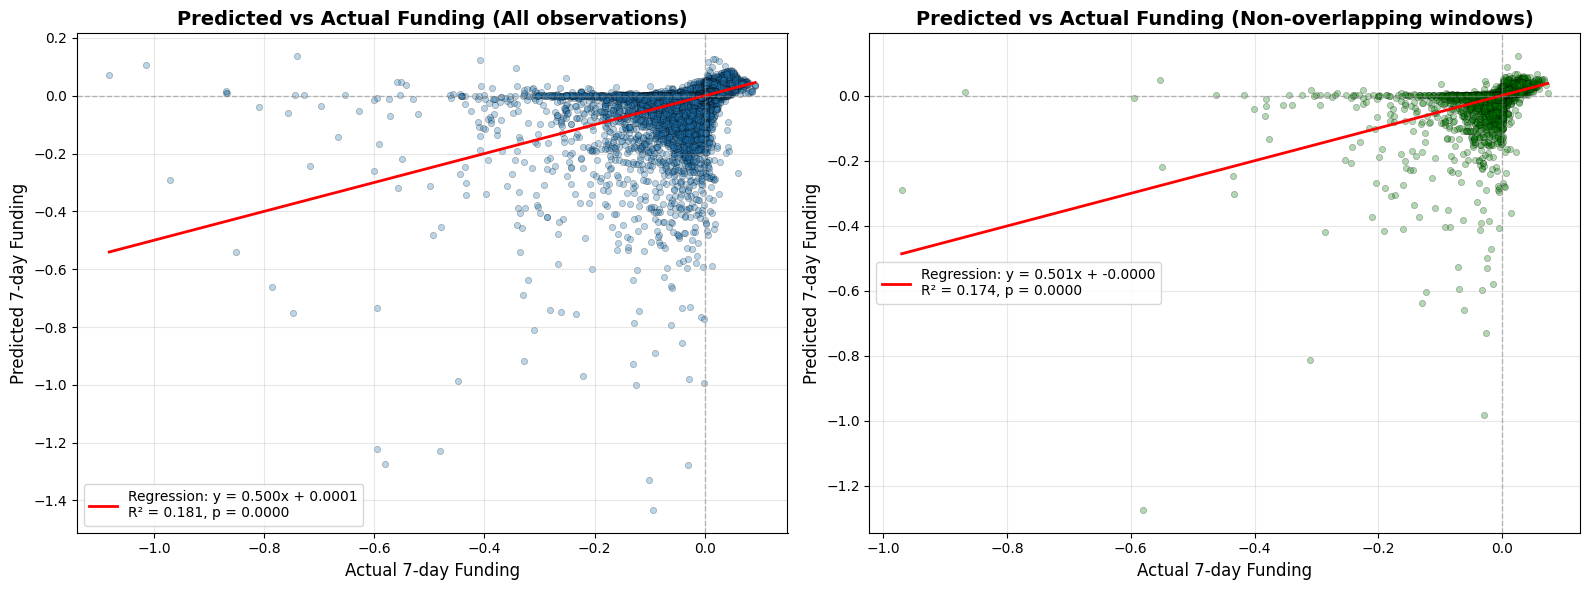


All observations:
  Observations: 367931
  Correlation: 0.4258
  R-squared: 0.1813
  p-value: 0.0000

Non-overlapping windows:
  Observations: 52759
  Correlation: 0.4169
  R-squared: 0.1738
  p-value: 0.0000


In [7]:
# Create scatter plots of predicted vs actual funding

# Overall scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All overlapping data
axes[0].scatter(df_forecast['actual_funding'], df_forecast['predicted_funding'], 
                alpha=0.3, s=20, edgecolors='black', linewidth=0.5)

# Calculate and plot regression line
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    df_forecast['actual_funding'], df_forecast['predicted_funding']
)
x_line1 = np.array([df_forecast['actual_funding'].min(), df_forecast['actual_funding'].max()])
y_line1 = slope1 * x_line1 + intercept1
axes[0].plot(x_line1, y_line1, 'r-', linewidth=2, 
            label=f'Regression: y = {slope1:.3f}x + {intercept1:.4f}\nR² = {r_value1**2:.3f}, p = {p_value1:.4f}')

# Add horizontal and vertical lines at zero
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

axes[0].set_xlabel('Actual 7-day Funding', fontsize=12)
axes[0].set_ylabel('Predicted 7-day Funding', fontsize=12)
axes[0].set_title('Predicted vs Actual Funding (All observations)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Non-overlapping windows (sample every 7th row)
df_forecast_sampled = df_forecast.groupby('symbol').apply(lambda x: x.iloc[::7], include_groups=False).reset_index(drop=True)
axes[1].scatter(df_forecast_sampled['actual_funding'], df_forecast_sampled['predicted_funding'], 
                alpha=0.3, s=20, color='green', edgecolors='black', linewidth=0.5)

# Calculate and plot regression line
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    df_forecast_sampled['actual_funding'], df_forecast_sampled['predicted_funding']
)
x_line2 = np.array([df_forecast_sampled['actual_funding'].min(), df_forecast_sampled['actual_funding'].max()])
y_line2 = slope2 * x_line2 + intercept2
axes[1].plot(x_line2, y_line2, 'r-', linewidth=2, 
            label=f'Regression: y = {slope2:.3f}x + {intercept2:.4f}\nR² = {r_value2**2:.3f}, p = {p_value2:.4f}')

# Add horizontal and vertical lines at zero
axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

axes[1].set_xlabel('Actual 7-day Funding', fontsize=12)
axes[1].set_ylabel('Predicted 7-day Funding', fontsize=12)
axes[1].set_title('Predicted vs Actual Funding (Non-overlapping windows)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAll observations:")
print(f"  Observations: {len(df_forecast)}")
print(f"  Correlation: {r_value1:.4f}")
print(f"  R-squared: {r_value1**2:.4f}")
print(f"  p-value: {p_value1:.4f}")

print(f"\nNon-overlapping windows:")
print(f"  Observations: {len(df_forecast_sampled)}")
print(f"  Correlation: {r_value2:.4f}")
print(f"  R-squared: {r_value2**2:.4f}")
print(f"  p-value: {p_value2:.4f}")

### Load perpetual futures and spot OHLVC data

In [18]:
# Load spot and perpetual OHLCV data
df_spot = pd.read_csv('binance_spot_ohlcv_history.csv')
df_perp = pd.read_csv('binance_perp_ohlcv_history.csv')

# Convert datetime to datetime format
df_spot['datetime'] = pd.to_datetime(df_spot['datetime'])
df_perp['datetime'] = pd.to_datetime(df_perp['datetime'])

# Clean symbol names: remove '/' from spot and '/' + ':USDT' from perp
df_spot['symbol'] = df_spot['symbol'].str.replace('/', '', regex=False)
df_perp['symbol'] = df_perp['symbol'].str.replace('/', '', regex=False).str.replace(':USDT', '', regex=False)

# Select only needed columns
df_spot_clean = df_spot[['datetime', 'symbol', 'close', 'volume']].copy()
df_perp_clean = df_perp[['datetime', 'symbol', 'close', 'volume']].copy()

# Rename columns to distinguish spot and perp
df_spot_clean = df_spot_clean.rename(columns={'close': 'close_spot', 'volume': 'volume_spot'})
df_perp_clean = df_perp_clean.rename(columns={'close': 'close_perp', 'volume': 'volume_perp'})

# Merge on datetime and symbol
df_combined = pd.merge(df_spot_clean, df_perp_clean, on=['datetime', 'symbol'], how='inner')

# Calculate notional volume in USDT for both spot and perp
df_combined['notional_volume_spot'] = df_combined['volume_spot'] * df_combined['close_spot']
df_combined['notional_volume_perp'] = df_combined['volume_perp'] * df_combined['close_perp']

# Calculate average notional volume
df_combined['volume'] = (df_combined['notional_volume_spot'] + df_combined['notional_volume_perp']) / 2

# Calculate 5-day rolling average of volume
df_combined['volume_ma5'] = df_combined.groupby('symbol')['volume'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean())

# Add universe column: True if 5-day average volume > $2M
df_combined['universe'] = df_combined['volume_ma5'] > 2e6

# Select final columns
df_ohlcv = df_combined[['datetime', 'symbol', 'close_spot', 'close_perp', 'volume_ma5', 'universe']].copy()

print(f"Loaded {len(df_ohlcv)} rows across {df_ohlcv['symbol'].nunique()} symbols")
print(f"Date range: {df_ohlcv['datetime'].min()} to {df_ohlcv['datetime'].max()}")
print("\nFirst few rows:")
print(df_ohlcv.head(2))

Loaded 313384 rows across 374 symbols
Date range: 2021-01-23 00:00:00 to 2026-01-22 00:00:00

First few rows:
    datetime   symbol  close_spot  close_perp    volume_ma5  universe
0 2021-01-23  BTCUSDT    32078.00    32086.48  5.155569e+09      True
1 2021-01-24  BTCUSDT    32259.90    32275.63  4.756848e+09      True
2 2021-01-25  BTCUSDT    32254.20    32253.68  5.349367e+09      True
3 2021-01-26  BTCUSDT    32467.77    32474.14  5.764887e+09      True
4 2021-01-27  BTCUSDT    30366.15    30381.04  6.212650e+09      True


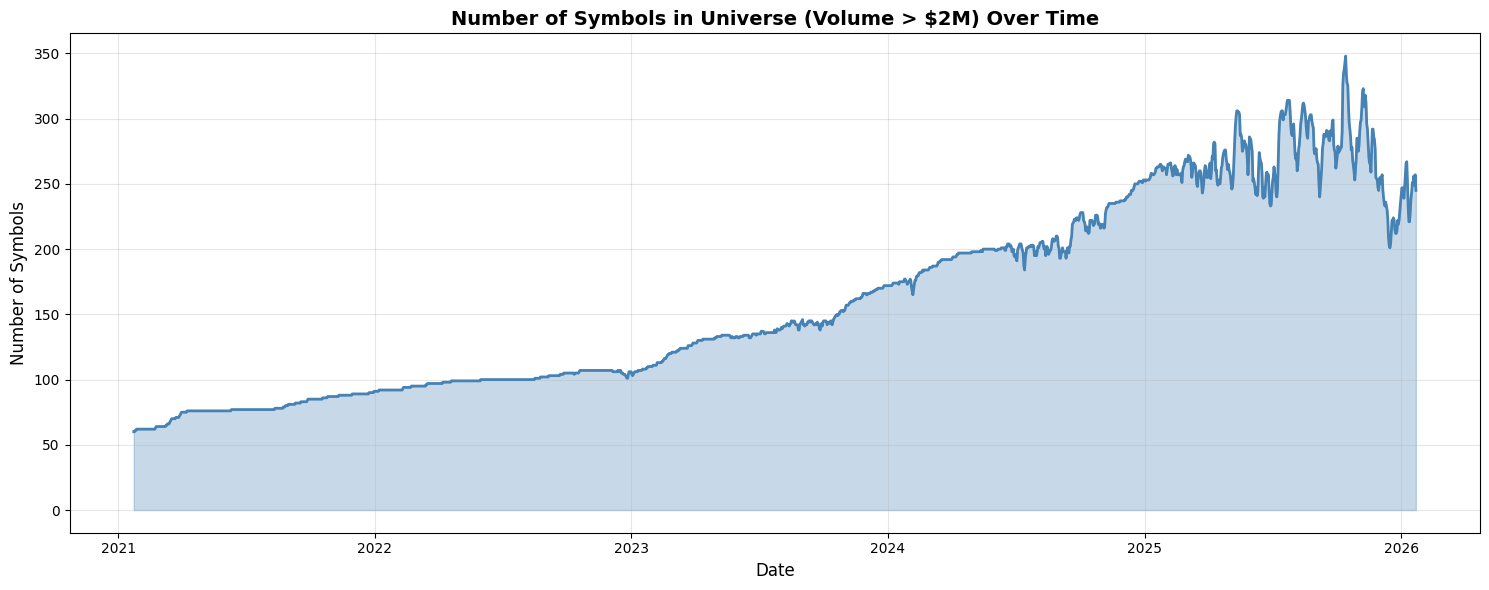

In [19]:
# Count the number of distinct symbols where universe = True for each day
universe_count = df_ohlcv[df_ohlcv['universe'] == True].groupby('datetime')['symbol'].nunique()

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(universe_count.index, universe_count.values, linewidth=2, color='steelblue')
plt.fill_between(universe_count.index, universe_count.values, alpha=0.3, color='steelblue')
plt.title('Number of Symbols in Universe (Volume > $2M) Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Symbols', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Merge funding rates into ohlcv dataframe
df_ohlcv = df_ohlcv.merge(
    df_daily_wide.reset_index().melt(id_vars='funding_time', var_name='symbol', value_name='funding_rate'),
    left_on=['datetime', 'symbol'],
    right_on=['funding_time', 'symbol'],
    how='left'
)

# Sort for forward calculations
df_ohlcv = df_ohlcv.sort_values(['symbol', 'datetime'])

# Calculate forward spot and perp returns (holding from t to t+1)
df_ohlcv['spot_return_fwd'] = df_ohlcv.groupby('symbol')['close_spot'].pct_change().shift(-1)
df_ohlcv['perp_return_fwd'] = df_ohlcv.groupby('symbol')['close_perp'].pct_change().shift(-1)

# Align funding: funding earned for holding from t to t+1 is funding_rate at t+1
df_ohlcv['funding_rate_fwd'] = df_ohlcv.groupby('symbol')['funding_rate'].shift(-1)

# Merge predicted funding into df_ohlcv
df_ohlcv = df_ohlcv.merge(
    df_forecast[['date', 'symbol', 'predicted_funding']],
    left_on=['datetime', 'symbol'],
    right_on=['date', 'symbol'],
    how='left'
)

In [37]:
# Set hurdle: 20% annualized converted to 7-day
hurdle_annual = 0.20
hurdle_7d = hurdle_annual * (7 / 365)
N = 10

def assign_positions(group):
    eligible = group[(group['universe']) & (group['predicted_funding'] > hurdle_7d)]
    top = eligible.nlargest(N, 'predicted_funding')
    group['pos'] = 0
    group.loc[top.index, 'pos'] = 1
    return group

df_ohlcv = df_ohlcv.groupby('datetime', group_keys=False).apply(assign_positions)

C:\Users\blazo\AppData\Local\Temp\ipykernel_10608\3443734471.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ohlcv = df_ohlcv.groupby('datetime', group_keys=False).apply(assign_positions)


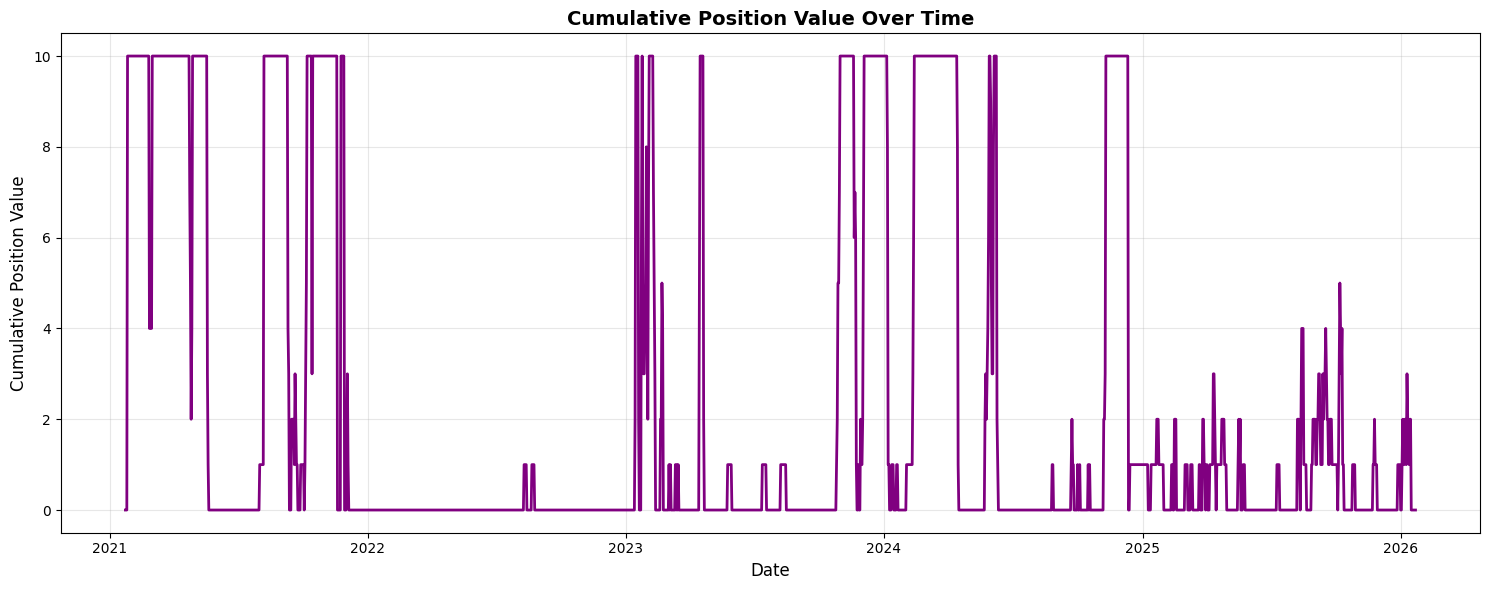

In [38]:
# Plot cumulative position count (number of active positions) over time

plt.figure(figsize=(15, 6))
cumulative_pos = df_ohlcv.groupby('datetime')['pos'].sum()
plt.plot(cumulative_pos.index, cumulative_pos.values, color='purple', linewidth=2)
plt.title('Cumulative Position Value Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Position Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
# Calculate trading costs based on position changes
# Cost is 0.15% (one-way) applied when position changes from 0->1 (entry) or 1->0 (exit)

# Calculate position change (shifted to detect transitions)
df_ohlcv['pos_prev'] = df_ohlcv.groupby('symbol')['pos'].shift(1).fillna(0)
df_ohlcv['pos_change'] = (df_ohlcv['pos'] != df_ohlcv['pos_prev']).astype(int)

# Trading cost: 0.15% when position changes (entry or exit)
one_way_cost = 0.0015
df_ohlcv['trade_cost'] = df_ohlcv['pos_change'] * one_way_cost

# Drop the temporary pos_prev column if not needed
df_ohlcv = df_ohlcv.drop('pos_prev', axis=1)

print(f"Total number of position changes: {df_ohlcv['pos_change'].sum()}")
print(f"Total trading cost: {df_ohlcv['trade_cost'].sum():.4f}")
print("\nFirst few rows with costs:")
print(df_ohlcv[df_ohlcv['trade_cost'] > 0][['datetime', 'symbol', 'pos', 'pos_change', 'trade_cost']].head(10))

Total number of position changes: 2426
Total trading cost: 3.6390

First few rows with costs:
      datetime          symbol  pos  pos_change  trade_cost
622 2025-05-17  1000CHEEMSUSDT    1           1      0.0015
623 2025-05-18  1000CHEEMSUSDT    0           1      0.0015
876 2023-12-15    1000SATSUSDT    1           1      0.0015
899 2024-01-07    1000SATSUSDT    0           1      0.0015
934 2024-02-11    1000SATSUSDT    1           1      0.0015
940 2024-02-17    1000SATSUSDT    0           1      0.0015
942 2024-02-19    1000SATSUSDT    1           1      0.0015
943 2024-02-20    1000SATSUSDT    0           1      0.0015
947 2024-02-24    1000SATSUSDT    1           1      0.0015
950 2024-02-27    1000SATSUSDT    0           1      0.0015



Top 20 symbols by position count / position changes ratio:
symbol
ALPINEUSDT    7.166667
MAGICUSDT     7.000000
DYDXUSDT      6.000000
BOMEUSDT      5.000000
WIFUSDT       4.250000
WUSDT         4.166667
IOTAUSDT      3.909091
ACTUSDT       3.750000
TSTUSDT       3.666667
PNUTUSDT      3.666667
FIOUSDT       3.363636
ANKRUSDT      3.250000
JTOUSDT       3.250000
NMRUSDT       3.000000
POWRUSDT      3.000000
SAHARAUSDT    3.000000
ORDIUSDT      2.916667
ARKUSDT       2.900000
METISUSDT     2.875000
PIXELUSDT     2.833333
dtype: float64


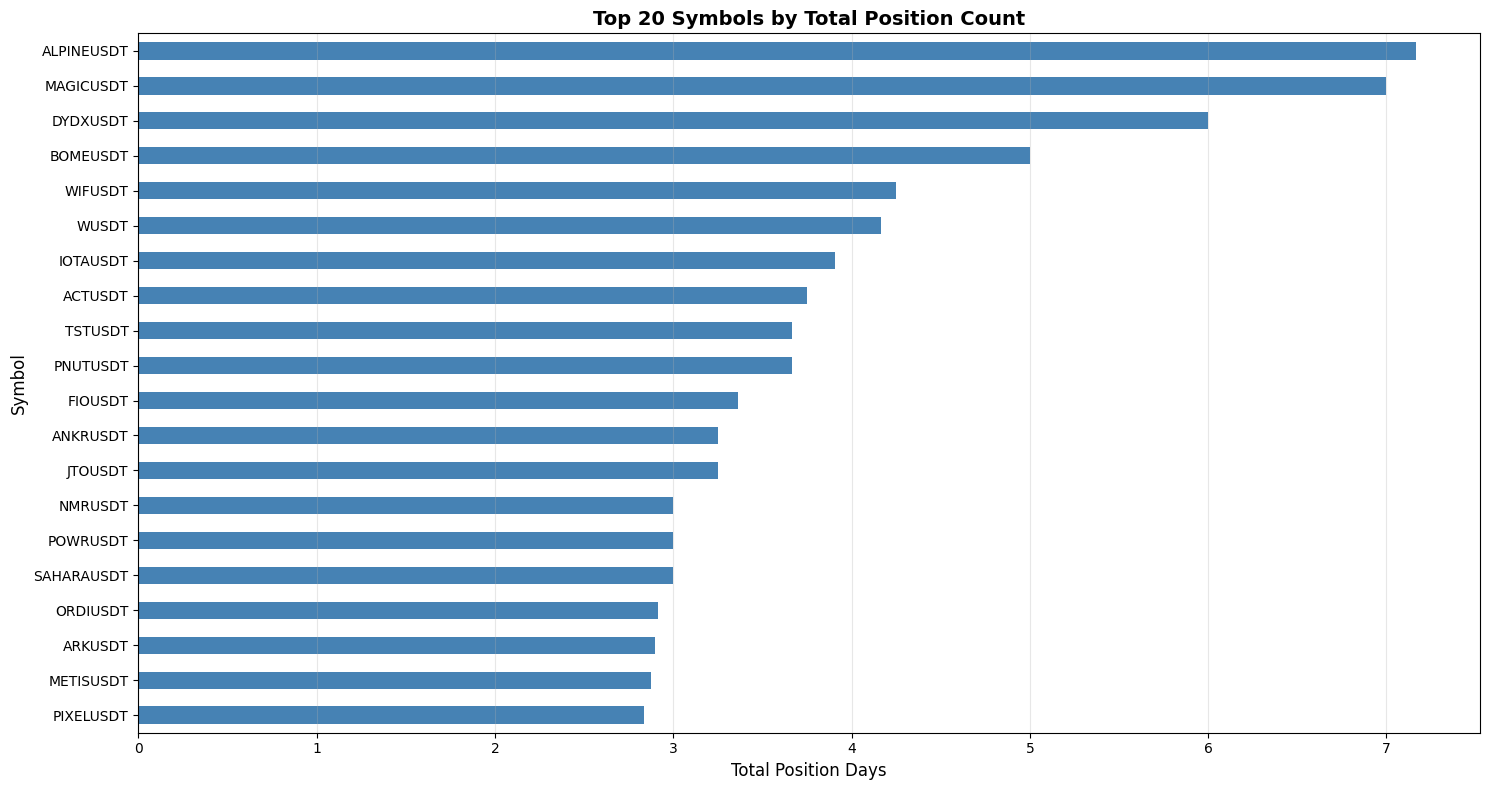

In [65]:
# Get top symbols by total position count (sum of pos)
top_symbols_by_pos = df_ohlcv.groupby('symbol')['pos'].sum().sort_values(ascending=False)
# Add pos_change as a separate column for analysis
top_symbols_by_change = df_ohlcv.groupby('symbol')['pos_change'].sum().sort_values(ascending=False)

# Calculate ratio of position count to position changes
top_symbols_ratio = (top_symbols_by_pos / top_symbols_by_change.replace(0, np.nan)).dropna().sort_values(ascending=False)

print("\nTop 20 symbols by position count / position changes ratio:")
print(top_symbols_ratio.head(20))

# Create a bar plot
plt.figure(figsize=(15, 8))
top_symbols_ratio.head(20).plot(kind='barh', color='steelblue')
plt.xlabel('Total Position Days', fontsize=12)
plt.ylabel('Symbol', fontsize=12)
plt.title('Top 20 Symbols by Total Position Count', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [68]:
df_1000sats = df_ohlcv[df_ohlcv['symbol'] == 'IOTAUSDT'].copy()

In [69]:
# Calculate total PnL for df_1000sats

# For positions (pos=1), calculate daily PnL components:
# 1. Perp PnL = -perp_return_fwd (short perp position)
# 2. Spot PnL = spot_return_fwd (long spot position)
# 3. Funding PnL = -funding_rate_fwd (receive funding when shorting perp with positive funding)
# 4. Trading costs

df_1000sats['perp_pnl'] = -df_1000sats['pos'] * df_1000sats['perp_return_fwd']
df_1000sats['spot_pnl'] = df_1000sats['pos'] * df_1000sats['spot_return_fwd']
df_1000sats['funding_pnl'] = df_1000sats['pos'] * df_1000sats['funding_rate_fwd']
df_1000sats['cost_pnl'] = -df_1000sats['trade_cost']

# Total daily PnL
df_1000sats['total_pnl'] = (df_1000sats['perp_pnl'] + 
                            df_1000sats['spot_pnl'] + 
                            df_1000sats['funding_pnl'] + 
                            df_1000sats['cost_pnl'])

# Calculate cumulative PnL
df_1000sats['cumulative_pnl'] = df_1000sats['total_pnl'].fillna(0).cumsum()

# Summary statistics
total_pnl = df_1000sats['total_pnl'].sum()
total_funding = df_1000sats['funding_pnl'].sum()
total_basis = (df_1000sats['perp_pnl'] + df_1000sats['spot_pnl']).sum()
total_costs = df_1000sats['cost_pnl'].sum()

print(f"1000SATSUSDT Total PnL Summary:")
print(f"Total PnL: {total_pnl:.6f} ({total_pnl*100:.4f}%)")
print(f"  Funding PnL: {total_funding:.6f} ({total_funding*100:.4f}%)")
print(f"  Basis PnL: {total_basis:.6f} ({total_basis*100:.4f}%)")
print(f"  Trading Costs: {total_costs:.6f} ({total_costs*100:.4f}%)")
print(f"\nNumber of trades: {df_1000sats['pos_change'].sum()}")
print(f"Days with position: {df_1000sats['pos'].sum()}")

1000SATSUSDT Total PnL Summary:
Total PnL: 0.217014 (21.7014%)
  Funding PnL: 0.246489 (24.6489%)
  Basis PnL: 0.003524 (0.3524%)
  Trading Costs: -0.033000 (-3.3000%)

Number of trades: 22
Days with position: 86


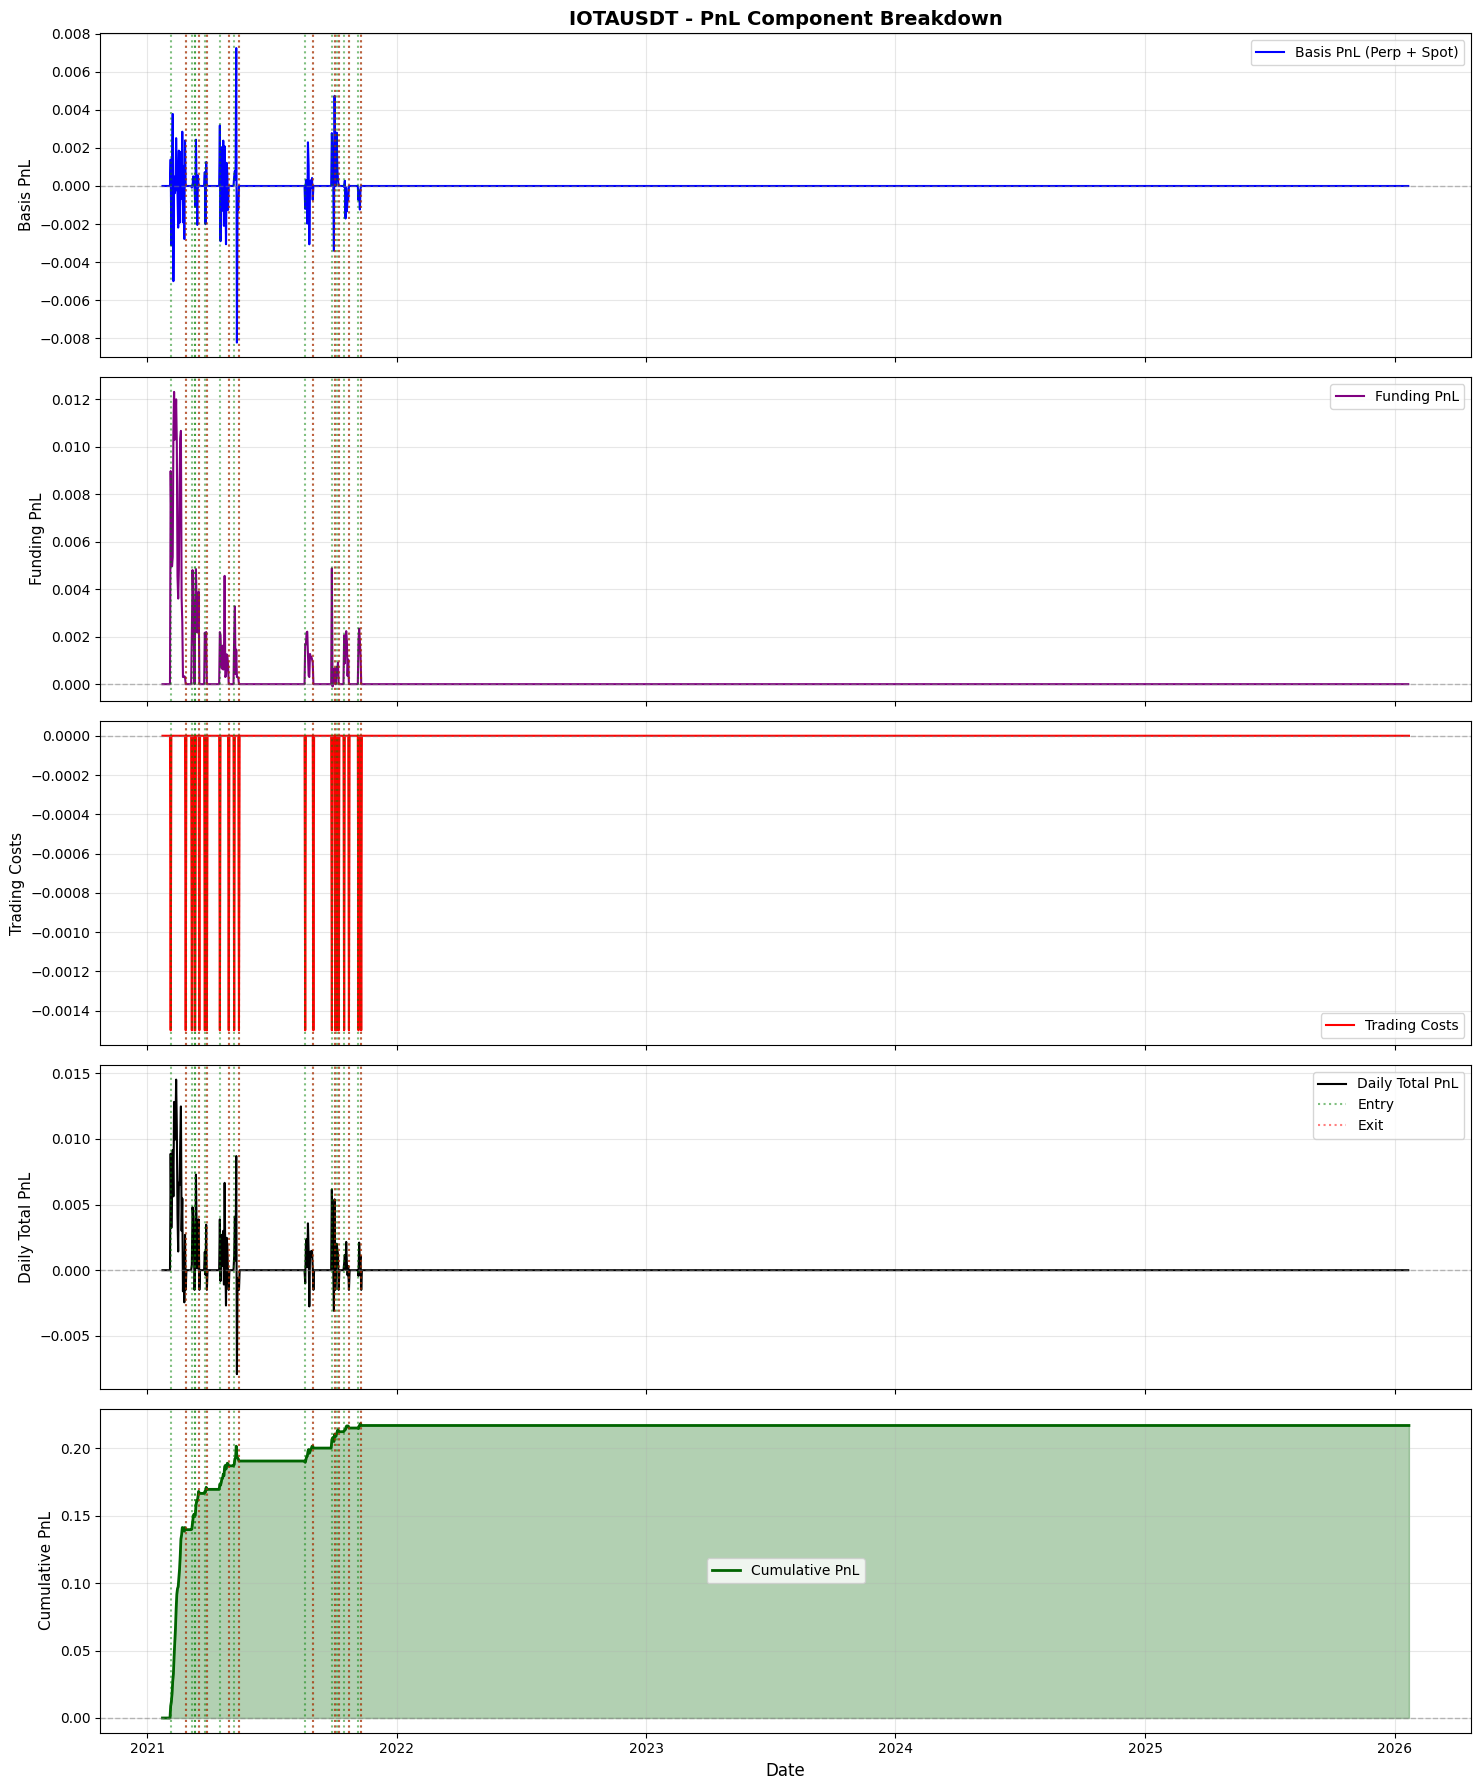


Number of entries: 22
Number of exits: 10


In [71]:
# Calculate total PnL for all symbols in df_ohlcv

# For positions (pos=1), calculate daily PnL components:
# 1. Perp PnL = -perp_return_fwd (short perp position)
# 2. Spot PnL = spot_return_fwd (long spot position)
# 3. Funding PnL = funding_rate_fwd (receive funding when shorting perp with positive funding)
# 4. Trading costs

df_ohlcv['perp_pnl'] = -df_ohlcv['pos'] * df_ohlcv['perp_return_fwd']
df_ohlcv['spot_pnl'] = df_ohlcv['pos'] * df_ohlcv['spot_return_fwd']
df_ohlcv['funding_pnl'] = df_ohlcv['pos'] * df_ohlcv['funding_rate_fwd']
df_ohlcv['cost_pnl'] = -df_ohlcv['trade_cost']

# Total daily PnL
df_ohlcv['total_pnl'] = (df_ohlcv['perp_pnl'] + 
                         df_ohlcv['spot_pnl'] + 
                         df_ohlcv['funding_pnl'] + 
                         df_ohlcv['cost_pnl'])

# Calculate portfolio-level daily PnL (sum across all symbols each day)
portfolio_daily_pnl = df_ohlcv.groupby('datetime')['total_pnl'].sum()

# Calculate cumulative portfolio PnL
portfolio_cumulative_pnl = portfolio_daily_pnl.fillna(0).cumsum()

# Summary statistics
total_pnl = df_ohlcv['total_pnl'].sum()
total_funding = df_ohlcv['funding_pnl'].sum()
total_basis = (df_ohlcv['perp_pnl'] + df_ohlcv['spot_pnl']).sum()
total_costs = df_ohlcv['cost_pnl'].sum()

print(f"Portfolio Total PnL Summary:")
print(f"Total PnL: {total_pnl:.6f} ({total_pnl*100:.4f}%)")
print(f"  Funding PnL: {total_funding:.6f} ({total_funding*100:.4f}%)")
print(f"  Basis PnL: {total_basis:.6f} ({total_basis*100:.4f}%)")
print(f"  Trading Costs: {total_costs:.6f} ({total_costs*100:.4f}%)")
print(f"\nTotal number of trades: {df_ohlcv['pos_change'].sum()}")
print(f"Total position-days: {df_ohlcv['pos'].sum()}")
print(f"Number of unique symbols traded: {df_ohlcv[df_ohlcv['pos'] > 0]['symbol'].nunique()}")

Portfolio Total PnL Summary:
Total PnL: 3.360353 (336.0353%)
  Funding PnL: 6.869797 (686.9797%)
  Basis PnL: 0.129556 (12.9556%)
  Trading Costs: -3.639000 (-363.9000%)

Total number of trades: 2426
Total position-days: 4182
Number of unique symbols traded: 236


In [86]:
# Aggregate total_pnl to daily basis (sum across all symbols for each day)
daily_pnl = df_ohlcv.groupby('datetime')['total_pnl'].sum()

print(f"Daily PnL shape: {daily_pnl.shape}")
print(f"Date range: {daily_pnl.index.min()} to {daily_pnl.index.max()}")
print("\nFirst 10 days:")
print(daily_pnl.head(10))
print("\nLast 10 days:")
print(daily_pnl.tail(10))

Daily PnL shape: (1826,)
Date range: 2021-01-23 00:00:00 to 2026-01-22 00:00:00

First 10 days:
datetime
2021-01-23    0.000000
2021-01-24    0.000000
2021-01-25    0.000000
2021-01-26   -0.007212
2021-01-27    0.003097
2021-01-28    0.025011
2021-01-29    0.019636
2021-01-30    0.045920
2021-01-31    0.030234
2021-02-01    0.024734
Name: total_pnl, dtype: float64

Last 10 days:
datetime
2026-01-13   -0.000933
2026-01-14   -0.003076
2026-01-15    0.001177
2026-01-16   -0.003000
2026-01-17    0.000000
2026-01-18    0.000000
2026-01-19    0.000000
2026-01-20    0.000000
2026-01-21    0.000000
2026-01-22    0.000000
Name: total_pnl, dtype: float64


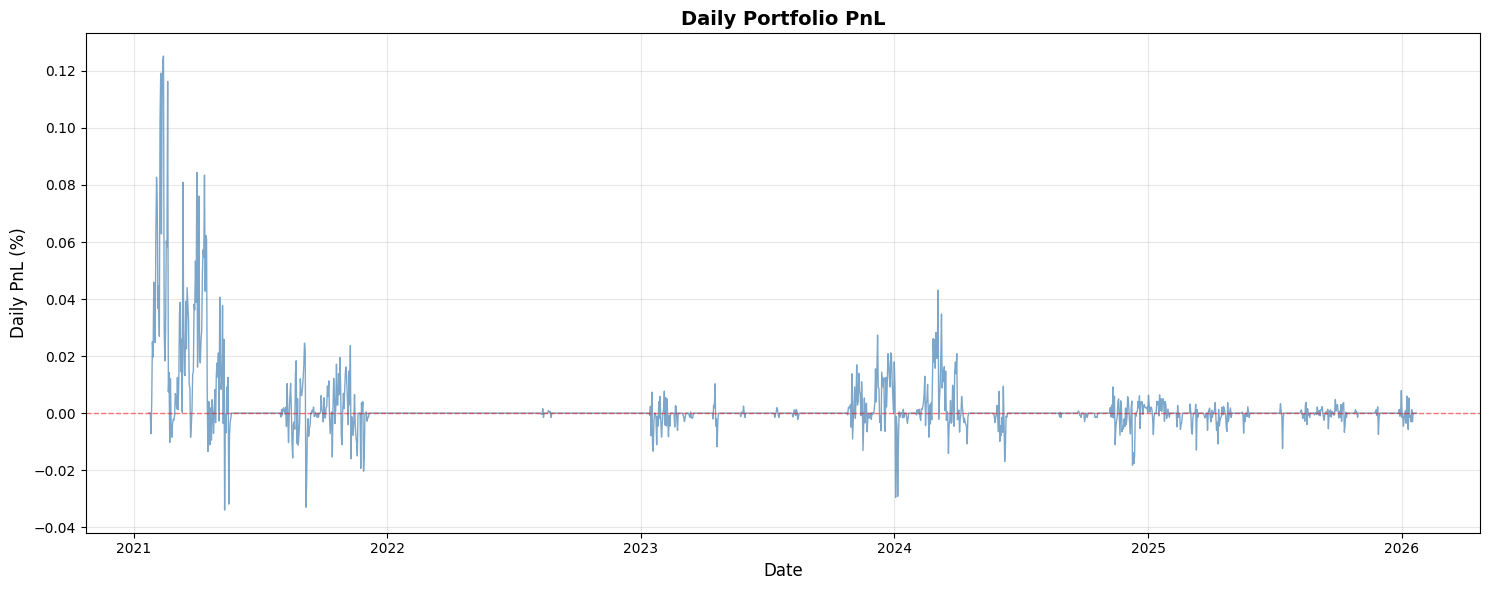


Daily PnL Statistics:
Mean: 0.001840 (0.1840%)
Std: 0.011120 (1.1120%)
Min: -0.033970 (-3.3970%)
Max: 0.125204 (12.5204%)
Sharpe (annualized): 3.1618


In [87]:
# Plot daily PnL
plt.figure(figsize=(15, 6))
plt.plot(daily_pnl.index, daily_pnl.values, linewidth=1, alpha=0.7, color='steelblue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Daily Portfolio PnL', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily PnL (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDaily PnL Statistics:")
print(f"Mean: {daily_pnl.mean():.6f} ({daily_pnl.mean()*100:.4f}%)")
print(f"Std: {daily_pnl.std():.6f} ({daily_pnl.std()*100:.4f}%)")
print(f"Min: {daily_pnl.min():.6f} ({daily_pnl.min()*100:.4f}%)")
print(f"Max: {daily_pnl.max():.6f} ({daily_pnl.max()*100:.4f}%)")
print(f"Sharpe (annualized): {(daily_pnl.mean() / daily_pnl.std()) * np.sqrt(365):.4f}")

In [ ]:
# Plot cumulative PnL
plt.figure(figsize=(15, 6))
plt.plot(portfolio_cumulative_pnl.index, portfolio_cumulative_pnl.values, linewidth=2, color='darkgreen')
plt.fill_between(portfolio_cumulative_pnl.index, portfolio_cumulative_pnl.values, alpha=0.3, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Cumulative Portfolio PnL', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative PnL (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final cumulative PnL
print(f"\nFinal Cumulative PnL: {portfolio_cumulative_pnl.iloc[-1]:.6f} ({portfolio_cumulative_pnl.iloc[-1]*100:.4f}%)")